In [64]:
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
import jax.numpy as jnp
import jax
import equinox as eqx
import diffrax
import time
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)


# def f(t, y, args):
#     return -y

# term = ODETerm(f)
# solver = Dopri5()
# y0 = jnp.array([2., 3.])
# solution = diffeqsolve(term, solver, t0=0, t1=1, dt0=0.1, y0=y0)

class BioProcess(eqx.Module):
    qsmax:float
    Ks: float
    a:float
    ms:float

    def __call__(self,t,y,args):
        # y.at[0].set(jnp.where(y[0]<0,0,y[0]))
        qs=self.qsmax*(y[0]/(self.Ks+y[0]))
        qx=(qs-self.ms)/self.a
        Rs=qs*y[1]
        Rx=qx*y[1]
        return jnp.stack([Rs,Rx])

@jax.jit
def main(qsmax,Ks,a,ms):
    bioprocess=BioProcess(qsmax,Ks,a,ms)
    terms = diffrax.ODETerm(bioprocess)
    t0 = 0.0
    t1 = 100.0
    y0 = jnp.array([3.0, 0.01])
    dt0 = 0.0002
    solver = diffrax.Kvaerno5()
    saveat = diffrax.SaveAt(ts=jnp.arange(0,100,0.1))
    stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)
    sol = diffrax.diffeqsolve(
        terms,
        solver,
        t0,
        t1,
        dt0,
        y0,
        saveat=saveat,
        stepsize_controller=stepsize_controller,
    )
    return sol


main(-0.3,0.01,-1.6,-0.01)

start = time.time()
sol = main(-0.4,0.01,-1.6,-0.01)
end = time.time()


AttributeError: 'Solution' object has no attribute 'grad'

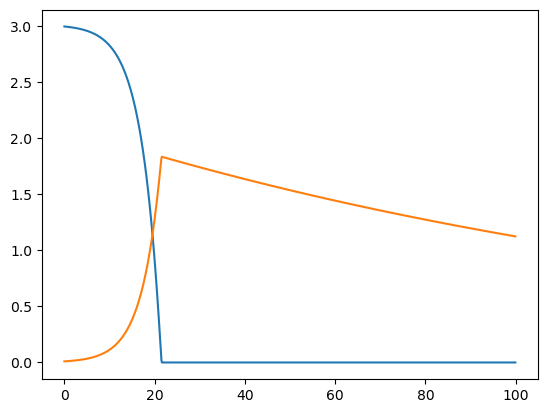

In [63]:
plt.plot(sol.ts,sol.ys[:,0])
plt.plot(sol.ts,sol.ys[:,1])

In [66]:
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

In [91]:

class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key):
        wkey, bkey = jax.random.split(key)
        self.weight = jax.random.normal(wkey, (out_size, in_size))
        self.bias = jax.random.normal(bkey, (out_size,))

    def __call__(self, x):
        return self.weight @ x + self.bias
    
@jax.jit
# @jax.grad
def loss_fn(model, x, y):
    pred_y = jax.vmap(model)(x)
    return jax.numpy.mean((y - pred_y) ** 2)

batch_size, in_size, out_size = 32, 2, 3
model = Linear(in_size, out_size, key=jax.random.PRNGKey(0))
x = jax.numpy.zeros((batch_size, in_size))
y = jax.numpy.zeros((batch_size, out_size))
grads = loss_fn(model, x, y)



In [95]:
jax.pytree(model)

AttributeError: module 'jax' has no attribute 'pytree'

Neural ODE

In [109]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.relu,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y)

class NeuralODE(eqx.Module):
    func: Func
    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [110]:
def _get_data(ts, *, key):
    y0 = jr.uniform(key, (2,), minval=-0.6, maxval=1)

    def f(t, y, args):
        x = y / (1 + y)
        return jnp.stack([x[1], -x[0]], axis=-1)

    solver = diffrax.Tsit5()
    dt0 = 0.1
    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(f), solver, ts[0], ts[-1], dt0, y0, saveat=saveat
    )
    ys = sol.ys
    return ys


def get_data(dataset_size, *, key):
    ts = jnp.linspace(0, 10, 100)
    key = jr.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys

def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

Step: 0, Loss: 0.04396583631903845, Computation time: 5.151034832000732
Step: 100, Loss: 0.0004904811131941321, Computation time: 0.0068056583404541016
Step: 200, Loss: 0.000729443786467207, Computation time: 0.008174419403076172
Step: 300, Loss: 5.3555838132552915e-05, Computation time: 0.010764837265014648
Step: 400, Loss: 2.258881679891483e-05, Computation time: 0.010375738143920898
Step: 499, Loss: 1.702016504269502e-05, Computation time: 0.00882267951965332
Step: 0, Loss: 0.0005563075702917618, Computation time: 4.455637216567993
Step: 100, Loss: 0.0017470687347177086, Computation time: 0.03913259506225586
Step: 200, Loss: 0.0012453609891676114, Computation time: 0.039980411529541016
Step: 300, Loss: 0.0003148921906717744, Computation time: 0.03622841835021973
Step: 400, Loss: 0.00042940109570576454, Computation time: 0.041715383529663086
Step: 499, Loss: 0.0008667313567857229, Computation time: 0.04892778396606445


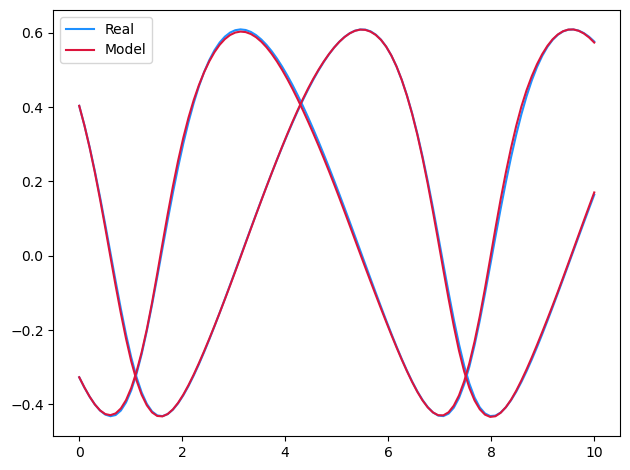

In [111]:
def main(
    dataset_size=256,
    batch_size=32,
    lr_strategy=(3e-3, 3e-3),
    steps_strategy=(500, 500),
    length_strategy=(0.1, 1),
    width_size=64,
    depth=2,
    seed=5678,
    plot=True,
    print_every=100,
):
    key = jr.PRNGKey(seed)
    data_key, model_key, loader_key = jr.split(key, 3)

    ts, ys = get_data(dataset_size, key=data_key)
    _, length_size, data_size = ys.shape

    model = NeuralODE(data_size, width_size, depth, key=model_key)

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
        return jnp.mean((yi - y_pred) ** 2)

    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]
        for step, (yi,) in zip(
            range(steps), dataloader((_ys,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state = make_step(_ts, yi, model, opt_state)
            end = time.time()
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    if plot:
        plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
        plt.plot(ts, ys[0, :, 1], c="dodgerblue")
        model_y = model(ts, ys[0, 0])
        plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
        plt.plot(ts, model_y[:, 1], c="crimson")
        plt.legend()
        plt.tight_layout()
        plt.savefig("neural_ode.png")
        plt.show()

    return ts, ys, model


ts, ys, model = main()

In [ ]:
class Stack(eqx.Module):
    modules: list[eqx.Module]

    def __call__(self, x):
        assert x.shape[-1] == 2
        x0 = x[..., 0]
        x1 = x[..., 1]
        return jnp.stack([module(x0=x0, x1=x1) for module in self.modules], axis=-1)


def quantise(expr, quantise_to):
    if isinstance(expr, sympy.Float):
        return expr.func(round(float(expr) / quantise_to) * quantise_to)
    elif isinstance(expr, sympy.Symbol):
        return expr
    else:
        return expr.func(*[quantise(arg, quantise_to) for arg in expr.args])

In [139]:
import tempfile
import pysr

[juliapkg] Locating Julia ~1.6.7, ~1.7, ~1.8, ~1.9, =1.10.0, ^1.10.3
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.10.3 to /home/plent/anaconda3/envs/jax_env/julia_env/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to have Julia
[juliapkg]   installed in multiple locations. It is recommended to install JuliaUp
[juliapkg]   (https://github.com/JuliaLang/juliaup) or Julia (https://julialang.org/downloads)
[juliapkg]   yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.3-linux-x86_64.tar.gz
             downloaded 33.7 MB of 165.5 MB
             downloaded 69.6 MB of 165.5 MB
             downloaded 102.2 MB of 165.5 MB
             downloaded 135.2 MB of 165.5 MB
             download complete
[juliapkg] Verifying download
[juliapkg] Installing Julia 1.10.3 to /home/plent/anaconda3/envs/ja

  Installing known registries into `~/.julia`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed IrrationalConstants ───────── v0.2.2
   Installed MicroMamba ────────────────── v0.1.14
   Installed Adapt ─────────────────────── v4.0.4
   Installed Tricks ────────────────────── v0.1.8
   Installed Scratch ───────────────────── v1.2.1
   Installed ScientificTypesBase ───────── v3.0.0
   Installed DiffRules ─────────────────── v1.15.1
   Installed DynamicExpressions ────────── v0.16.0
   Installed JSON3 ─────────────────────── v1.14.0
   Installed TableTraits ───────────────── v1.0.1
   Installed Preferences ───────────────── v1.4.3
   Installed DiffResults ───────────────── v1.1.0
   Installed MLJModelInterface ─────────── v1.9.6
   Installed StatisticalTraits ─────────── v3.2.0
   Installed PositiveFactorizations ────── v0.2.4
   Installed PythonCall ────────────────── v0.9.20
   Installed Tables ────────────────────── v1.11.1
   In

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [143]:
def main(
    symbolic_dataset_size=2000,
    symbolic_num_populations=100,
    symbolic_population_size=20,
    symbolic_migration_steps=4,
    symbolic_mutation_steps=30,
    symbolic_descent_steps=50,
    pareto_coefficient=2,
    fine_tuning_steps=500,
    fine_tuning_lr=3e-3,
    quantise_to=0.01,
):
    #
    # First obtain a neural approximation to the dynamics.
    # We begin by running the previous example.
    #

    # Runs the Neural ODE example.
    # This defines the variables `ts`, `ys`, `model`.
    print("Training neural differential equation.")


    #
    # Now symbolically regress across the learnt vector field, to obtain a Pareto
    # frontier of symbolic equations, that trades loss against complexity of the
    # equation. Select the "best" from this frontier.
    #

    print("Symbolically regressing across the vector field.")
    vector_field = model.func.mlp  # noqa: F821
    dataset_size, length_size, data_size = ys.shape  # noqa: F821
    in_ = ys.reshape(dataset_size * length_size, data_size)  # noqa: F821
    in_ = in_[:symbolic_dataset_size]
    out = jax.vmap(vector_field)(in_)
    with tempfile.TemporaryDirectory() as tempdir:
        symbolic_regressor = pysr.PySRRegressor(
            niterations=symbolic_migration_steps,
            ncyclesperiteration=symbolic_mutation_steps,
            populations=symbolic_num_populations,
            population_size=symbolic_population_size,
            optimizer_iterations=symbolic_descent_steps,
            optimizer_nrestarts=1,
            procs=1,
            model_selection="score",
            progress=False,
            tempdir=tempdir,
            temp_equation_file=True,
        )
        symbolic_regressor.fit(in_, out)
        best_expressions = [b.sympy_format for b in symbolic_regressor.get_best()]
    print(best_expressions)
    #
    # Now the constants in this expression have been optimised for regressing across
    # the neural vector field. This was good enough to obtain the symbolic expression,
    # but won't quite be perfect -- some of the constants will be slightly off.
    #
    # To fix this we now plug our symbolic function back into the original dataset
    # and apply gradient descent.
    #

    print("\nOptimising symbolic expression.")

    symbolic_fn = Stack([sympy2jax.SymbolicModule(expr) for expr in best_expressions])
    symbolic_model = eqx.tree_at(lambda m: m.func.mlp, model, symbolic_fn)  # noqa: F821

    @eqx.filter_grad
    def grad_loss(symbolic_model):
        vmap_model = jax.vmap(symbolic_model, in_axes=(None, 0))
        pred_ys = vmap_model(ts, ys[:, 0])  # noqa: F821
        return jnp.mean((ys - pred_ys) ** 2)  # noqa: F821

    optim = optax.adam(fine_tuning_lr)
    opt_state = optim.init(eqx.filter(symbolic_model, eqx.is_inexact_array))

    @eqx.filter_jit
    def make_step(symbolic_model, opt_state):
        grads = grad_loss(symbolic_model)
        updates, opt_state = optim.update(grads, opt_state)
        symbolic_model = eqx.apply_updates(symbolic_model, updates)
        return symbolic_model, opt_state

    for _ in range(fine_tuning_steps):
        symbolic_model, opt_state = make_step(symbolic_model, opt_state)

    #
    # Finally we round each constant to the nearest multiple of `quantise_to`.
    #

    trained_expressions = []
    for symbolic_module in symbolic_model.func.mlp.modules:
        expression = symbolic_module.sympy()
        expression = quantise(expression, quantise_to)
        trained_expressions.append(expression)

    print(f"Expressions found: {trained_expressions}")


In [144]:
main()

Training neural differential equation.
Symbolically regressing across the vector field.


/home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/pysr/sr.py:870: FutureWarning: ncyclesperiteration has been renamed to ncycles_per_iteration in PySRRegressor. Please use that instead.
  warnings.warn(
[ Info: Started!


[x1/(x1 + 1.0083119), x0/(-x0 - 1.0269065)]

Optimising symbolic expression.


KeyError: 'Missing input for symbol Traced<ShapedArray(str64[])>with<DynamicJaxprTrace(level=5/0)>'